In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib

# Ignore warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Import TensorFlow/Keras for the LSTM model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from scikeras.wrappers import KerasRegressor


# Import your common functions (assumed to be defined in commons.py)
from commons import create_sequences, create_forecasting_sequences, load_data, add_advanced_time_features, add_lag_features, scale_data, filter_data_by_date, filter_last_x_days, plot_anomalies
from commons import timesteps  # Number of lags. Any lag longer then 100 will theoreticaly not work since we apply this model to the last 100 days for anomaly detection.

In [2]:
def build_lstm_forecaster_model(timesteps, n_features, units=64, dropout_rate=0.2, 
                                activation='relu', optimizer='adam'):
    """
    Baut ein LSTM-Modell für One-Step Forecasting mit den angegebenen Hyperparametern.
    
    Parameter:
        timesteps (int): Anzahl der Zeitschritte pro Input-Sequenz.
        n_features (int): Anzahl der Merkmale pro Zeitschritt.
        units (int): Anzahl der LSTM-Einheiten.
        dropout_rate (float): Dropout-Rate.
        activation (str): Aktivierungsfunktion.
        optimizer (str): Optimierer.
    
    Returns:
        model: Ein kompiliertes Keras-Modell.
    """
    model = Sequential()
    model.add(LSTM(units, activation=activation, input_shape=(timesteps, n_features), return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_features))  # Vorhersage der Merkmale des nächsten Zeitschritts
    model.compile(optimizer=optimizer, loss='mse')
    return model

def tune_lstm_forecaster(X_train, y_train, timesteps, n_features, param_grid, cv=3):
    """
    Führt ein Hyperparameter-Tuning für das LSTM-Modell mittels GridSearchCV durch.
    
    Parameter:
        X_train (np.array): Trainingssequenzen.
        y_train (np.array): Zielwerte zu den Trainingssequenzen.
        timesteps (int): Anzahl der Zeitschritte pro Input-Sequenz.
        n_features (int): Anzahl der Merkmale pro Zeitschritt.
        param_grid (dict): Dictionary mit den zu testenden Hyperparametern.
        cv (int): Anzahl der Cross-Validation-Folds.
        
    Returns:
        grid_search: Das gefittete GridSearchCV-Objekt (enthält u.a. grid_search.best_params_).
    """
    # Wrapper-Funktion zum Erstellen des Keras-Modells
    def create_model(units=64, dropout_rate=0.2, activation='relu', optimizer='adam'):
        return build_lstm_forecaster_model(timesteps, n_features, units=units, 
                                           dropout_rate=dropout_rate, activation=activation, optimizer=optimizer)
    
    # Umwandlung in einen scikit-learn-kompatiblen Regressor
    model = KerasRegressor(build_fn=create_model, verbose=0)
    
    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               cv=cv,
                               scoring='neg_mean_squared_error',  # Optimierung anhand des negativen MSE
                               n_jobs=1)
    
    grid_search.fit(X_train, y_train)
    print("Beste gefundene Parameter:", grid_search.best_params_)
    return grid_search

In [3]:
#########################################
# 1. Data Loading and Preprocessing
#########################################

# Load the dataset
data_file_path = 'SolarEdge_Tageswerte_Modified.csv'
data = load_data(data_file_path)
print("Data head:")
print(data.head())

# Add time-based features
data_with_time_features = add_advanced_time_features(data, 'Time')
print("After adding time features:")
print(data_with_time_features.head())

# Add lag features (using timesteps from commons)
data_with_lags = add_lag_features(data_with_time_features, target_column='Inv 1 AC-Leistung (W)', n_lags=timesteps)
print("After adding lag features:")
print(data_with_lags.head())

# Scale the data
scaler = StandardScaler()
scaled_data, scaled_feature_names = scale_data(
    scaler=scaler, 
    data=data_with_lags, 
    target_column='Inv 1 AC-Leistung (W)', 
    n_lags=timesteps  # dynamic number of lags
)
print("Scaled feature names:", scaled_feature_names)

Data head:
         Time  Inv 1 AC-Leistung (W)
0  04.12.2019              3309.0420
1  05.12.2019               167.5701
2  06.12.2019              1459.9454
3  07.12.2019              1349.0909
4  08.12.2019              2480.6001
After adding time features:
        Time  Inv 1 AC-Leistung (W)  hour  day  day_of_week  week_of_year  \
0 2019-12-04              3309.0420     0    4            2            49   
1 2019-12-05               167.5701     0    5            3            49   
2 2019-12-06              1459.9454     0    6            4            49   
3 2019-12-07              1349.0909     0    7            5            49   
4 2019-12-08              2480.6001     0    8            6            49   

   month  is_weekend  
0     12           0  
1     12           0  
2     12           0  
3     12           1  
4     12           1  
After adding lag features:
         Time  Inv 1 AC-Leistung (W)  hour  day  day_of_week  week_of_year  \
12 2019-12-16               799.3

In [4]:
# Filter the scaled data for training (excluding the last 100 days)
train_data_filtered = filter_data_by_date(
    data=scaled_data, 
    time_column='Time', 
    max_date_str='2024-02-15', 
    days_offset=200, 
    n_years_for_training=3
)
print("Filtered training data:")
print(train_data_filtered.head())

# Prepare the test data (last X days) for anomaly detection
last_x_days_data = filter_last_x_days(data_with_lags, time_column='Time', max_date_str='2024-02-15', days_offset=200)
print("Last X days data:")
print(last_x_days_data.head())

# Define feature columns (we assume that non-numeric or meta features are removed)
feature_columns = train_data_filtered.columns.difference(['Time', 'anomaly']).tolist()
print("Feature columns for LSTM:", feature_columns)

# Extract numeric data from the training set and cast to float32
train_numeric = train_data_filtered[feature_columns].values.astype('float32')

# Create training sequences for forecasting
X_train, y_train = create_forecasting_sequences(train_numeric, timesteps)

# Ensure the sequences are numeric
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

Filtered training data:
          Time  Inv 1 AC-Leistung (W)  hour  day  day_of_week  week_of_year  \
433 2021-02-15               1.690912     0   15            0             7   
434 2021-02-16               0.602360     0   16            1             7   
435 2021-02-17               0.375651     0   17            2             7   
436 2021-02-18               1.447376     0   18            3             7   
437 2021-02-19               0.782903     0   19            4             7   

     month  is_weekend     lag_1     lag_2     lag_3     lag_4     lag_5  \
433      2           0  1.685051  1.217007  0.318119  1.451144 -1.537434   
434      2           0  1.690564  1.685014  1.217121  0.317667  1.451142   
435      2           0  0.602894  1.690526  1.685537  1.216950  0.317668   
436      2           0  0.376368  0.602926  1.691054  1.685513  1.216950   
437      2           0  1.447225  0.376415  0.602502  1.691032  1.685512   

        lag_6     lag_7     lag_8     lag_9 

In [5]:
# Number of features in the input sequences
n_features = len(feature_columns)
print("Number of features for LSTM:", n_features)

param_grid = {
    'model__units': [32, 64],
    'model__dropout_rate': [0.2, 0.3],
    'epochs': [30, 50, 70, 100],
    'batch_size': [16, 32]
}

# Durchführung des Tuning-Prozesses

grid_search = tune_lstm_forecaster(X_train, y_train, timesteps, n_features, param_grid, cv=3)

# Auswahl des besten Modells aus der Grid Search
best_model = grid_search.best_estimator_

Number of features for LSTM: 19
Beste gefundene Parameter: {'batch_size': 16, 'epochs': 100, 'model__dropout_rate': 0.2, 'model__units': 64}


Shape of X_test: (186, 12, 19)
Shape of y_test: (186, 19)
Prediction errors (first 10): [0.27380076 0.34821358 0.38685066 0.32031322 0.23604873 0.2257068
 0.17034478 0.26143336 0.5135585  0.33743238]
Anomaly detection threshold: 4.1949005
Anomaly flags (first 10): [0 0 0 0 0 0 0 0 0 0]
Anomaly detection results:
   sequence_index  forecast_error  anomaly
0               0        0.273801        0
1               1        0.348214        0
2               2        0.386851        0
3               3        0.320313        0
4               4        0.236049        0


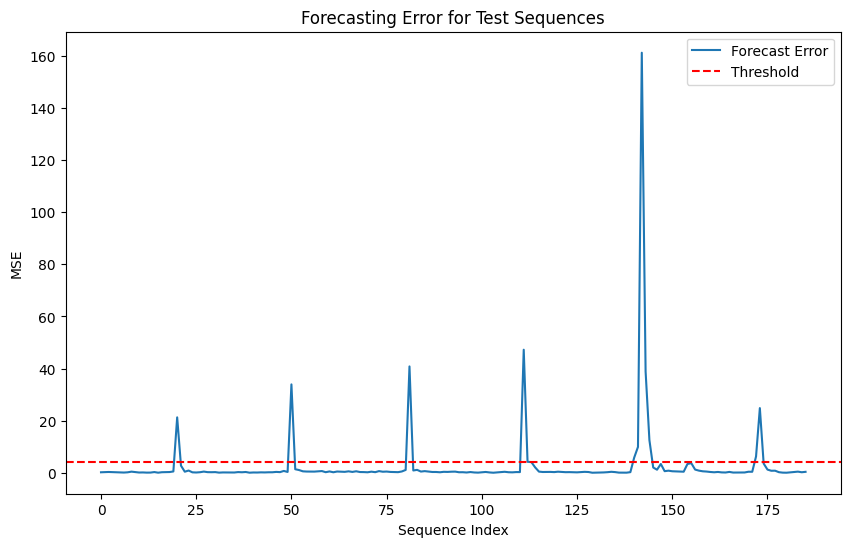

In [6]:
last_x_numeric = last_x_days_data[feature_columns].values.astype('float32')
X_test, y_test = create_forecasting_sequences(last_x_numeric, timesteps)
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

# Vorhersagen auf den Testsequenzen durchführen
y_pred = best_model.predict(X_test)

# Berechnung des Forecasting-Fehlers (MSE pro Sequenz)
errors = np.mean(np.power(y_test - y_pred, 2), axis=1)
print("Prediction errors (first 10):", errors[:10])

# Bestimmung eines Schwellwerts basierend auf dem Fehler im Training
y_train_pred = best_model.predict(X_train)
train_errors = np.mean(np.power(y_train - y_train_pred, 2), axis=1)
threshold = np.mean(train_errors) + 3 * np.std(train_errors)
print("Anomaly detection threshold:", threshold)

# Testsequenzen als Anomalie markieren, wenn der Fehler den Schwellwert überschreitet
anomaly_flags = (errors > threshold).astype(int)
print("Anomaly flags (first 10):", anomaly_flags[:10])

# Zusammenfassung der Ergebnisse in einem DataFrame
anomaly_results = pd.DataFrame({
    'sequence_index': np.arange(len(errors)),
    'forecast_error': errors,
    'anomaly': anomaly_flags
})
print("Anomaly detection results:")
print(anomaly_results.head())

# Plot der Forecasting-Fehler und des Schwellwerts
plt.figure(figsize=(10,6))
plt.plot(errors, label='Forecast Error')
plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
plt.title("Forecasting Error for Test Sequences")
plt.xlabel("Sequence Index")
plt.ylabel("MSE")
plt.legend()
plt.show()


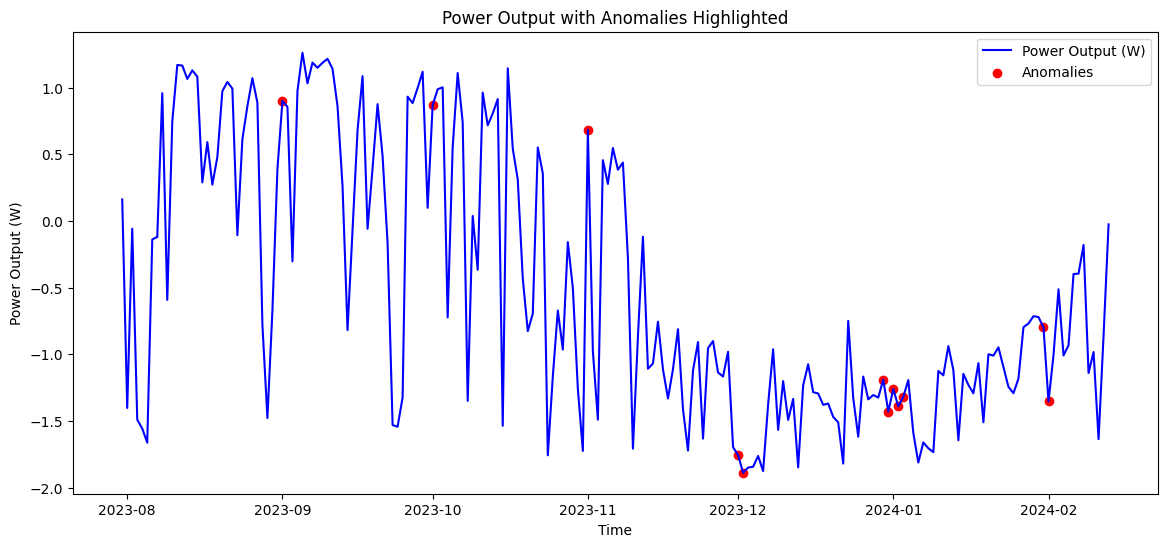

In [7]:
# ----- Mapping Forecast Anomalies Back to Original Data -----
# The forecasting sequences start at index 0 of the test data and each forecast corresponds to the time step at position i + timesteps.
# Create a new anomaly column for the full test dataset, initializing with zeros.
anomaly_full = np.zeros(len(last_x_days_data), dtype=int)

# For each forecast sequence, assign the anomaly flag to the corresponding time step.
# Note: This loop maps each sequence's forecast (i.e., the predicted error for time i+timesteps)
# to the original DataFrame index.
for i, flag in enumerate(anomaly_flags):
    index = i + timesteps  # This is the index in last_x_days_data that corresponds to the forecast target.
    if index < len(anomaly_full):  # safeguard in case of index overflow
        anomaly_full[index] = flag

# Add or update the 'anomaly' column in your test DataFrame.
last_x_days_data['anomaly'] = anomaly_full


# ----- Use the Visualization Function -----
plot_anomalies(last_x_days_data, time_column='Time', value_column='Inv 1 AC-Leistung (W)', anomaly_column='anomaly')

In [8]:
#########################################
# 6. (Optional) Save the Trained Model and Scaler
#########################################
best_model.model_.save("USModels/lstm_forecaster_model.keras")
joblib.dump(scaler, "USModels/scaler.save")

['USModels/scaler.save']

### Better Visualizations 

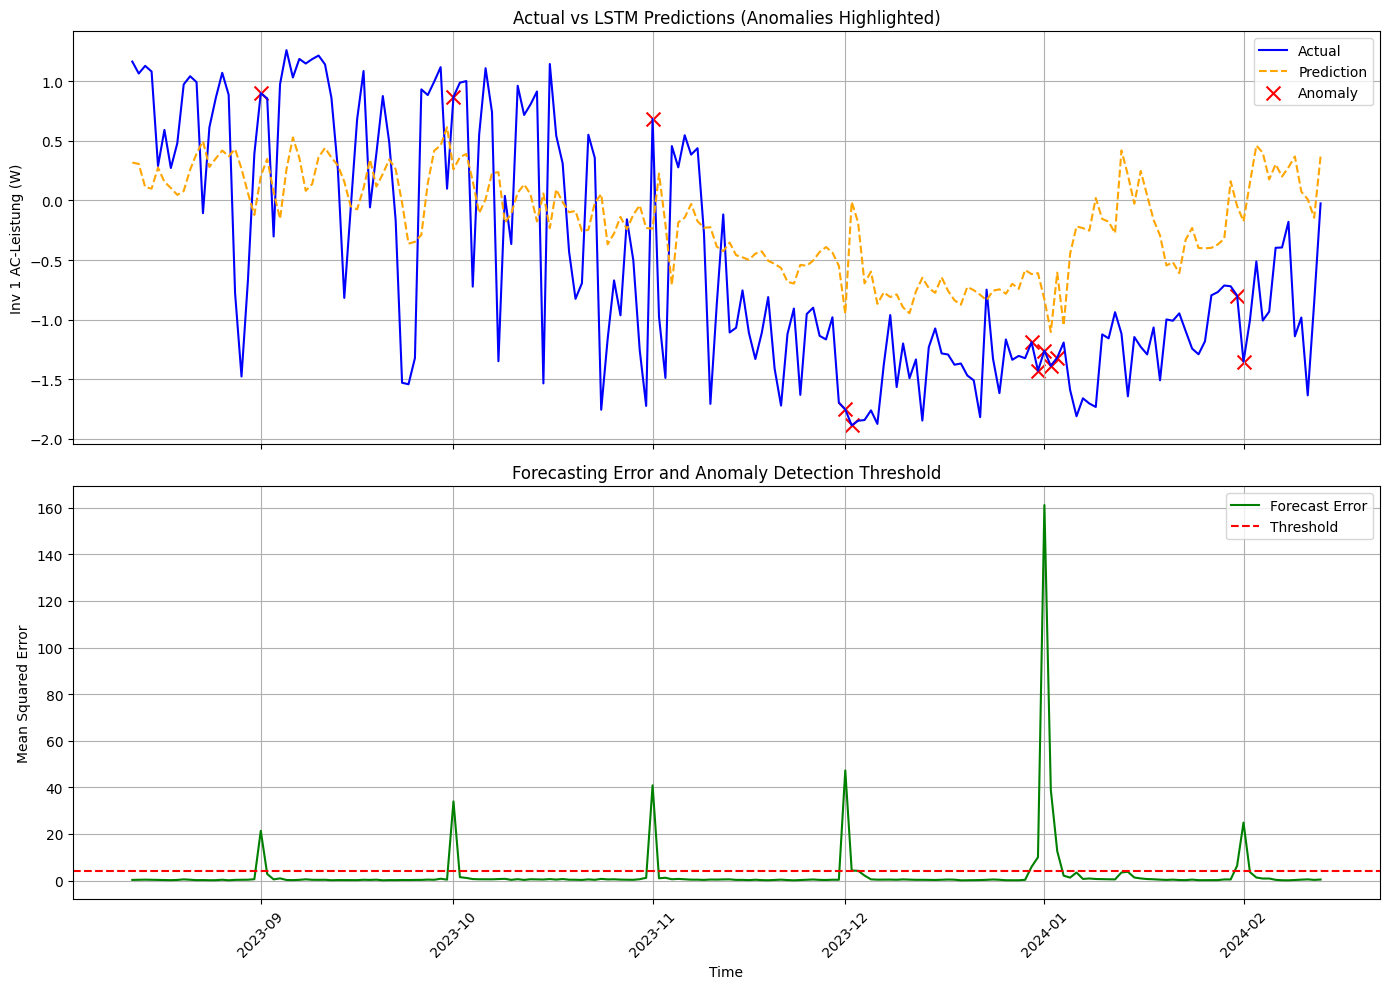

In [9]:
# --- Prepare visualization DataFrame ---
# Align predictions with the corresponding time indices.
# We assume that y_pred is an array of predictions with shape (num_samples, n_features)
# and that we are predicting the target column "Inv 1 AC-Leistung (W)".
# Since the predictions correspond to indices starting at 'timesteps', we slice last_x_days_data accordingly.
df_vis = last_x_days_data.iloc[timesteps:].copy()

# Add predictions for the first feature (adjust if your model predicts multiple features)
df_vis['Prediction'] = y_pred[:, 0]

# Calculate the forecasting error (MSE for each sequence) for visualization.
forecast_errors = np.mean((y_test - y_pred) ** 2, axis=1)
df_vis['ForecastError'] = forecast_errors

# --- Create the plots ---
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), sharex=True)

# Subplot 1: Actual vs Prediction with anomalies marked
axes[0].plot(df_vis['Time'], df_vis['Inv 1 AC-Leistung (W)'], label='Actual', color='blue')
axes[0].plot(df_vis['Time'], df_vis['Prediction'], label='Prediction', color='orange', linestyle='--')

# Mark anomalies on the actual data
# We assume that the anomaly flags have been mapped to last_x_days_data['anomaly'].
anomaly_mask = df_vis['anomaly'] == 1
axes[0].scatter(df_vis.loc[anomaly_mask, 'Time'],
                df_vis.loc[anomaly_mask, 'Inv 1 AC-Leistung (W)'],
                color='red', label='Anomaly', marker='x', s=100)

axes[0].set_title('Actual vs LSTM Predictions (Anomalies Highlighted)')
axes[0].set_ylabel('Inv 1 AC-Leistung (W)')
axes[0].legend()
axes[0].grid(True)

# Subplot 2: Forecast Error with the Anomaly Threshold
axes[1].plot(df_vis['Time'], df_vis['ForecastError'], label='Forecast Error', color='green')
axes[1].axhline(threshold, color='red', linestyle='--', label='Threshold')
axes[1].set_title('Forecasting Error and Anomaly Detection Threshold')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Mean Squared Error')
axes[1].legend()
axes[1].grid(True)

# Improve layout and rotate x-tick labels for better readability.
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()